In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

from ekfplot  import plot as ek
from ekfplot  import colors as ec
from ekfplot  import colorlists
from ekfstats import functions, fit, sampling

from astropy import units as u
from formica import modeling
from agrias import photometry, utils
import reader

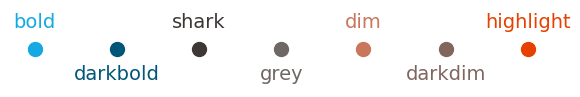

In [3]:
colorlists.display_colorlist(colorlists.merian)

In [4]:
from astropy.io import fits

In [5]:
import pandas as pd

In [6]:
galex_df = pd.read_csv('../local_data/intermediates/galex_df_w_specz.csv', index_col=0)

In [7]:
pzmin=0.#244
merian_select = reader.merianselect(pmin=pzmin, version=3)
merian_select['AV_est'] = reader.estimate_av(merian_select)

[merianselect] Only choosing sources with m_i < 28.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3
[merianselect] only choosing sources with griz photometry


/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
cosmo = modeling.cosmo

In [10]:
valid = (merian_select['r_cModelFlux_Merian'] >0.)&(merian_select['Mr']<-16.)
ms = merian_select[valid]
zcorr = np.log10((cosmo.luminosity_distance(ms['z_spec'])/cosmo.luminosity_distance(ms['z500']))**2)


fha_corrections = reader.compute_halphacorrections(ms, load_from_pickle=False, estimated_av=ms['AV_est'])
emission_correction, ge_correction, extinction_correction, aperture_correction = fha_corrections

ms['logmass_corrected'] = ms['logmass_gaap'] + zcorr + np.log10(aperture_correction)

Computed aperture correction in 0.0 seconds.
Computed line contamination in 0.0 seconds.
Computed Galactic extinction in 0.1 seconds.
Computed internal extinction in 0.1 seconds.


/Users/kadofong/work/projects/merian/agrias/notebooks/reader.py:306: RuntimeWarning: divide by zero encountered in reciprocal
  emission_correction = correct_N2_S3(
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_21301/1739883935.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ms['logmass_corrected'] = ms['logmass_gaap'] + zcorr + np.log10(aperture_correction)


In [11]:
n708_fluxes, n708_luminosities, n708_eqws, n708_fcont = photometry.mbestimate_halpha(
    ms[utils.photcols['N708']].values,
    ms[utils.photcols['g']].values,
    ms[utils.photcols['r']].values,
    ms[utils.photcols['i']].values,
    ms[utils.photcols['z']].values,
    ms['z_spec'].values,
    ms[utils.u_photcols['N708']].values,
    0.,
    0.,
    apercorr=aperture_correction.values,
    ge_correction=ge_correction[:,2],
    ex_correction=extinction_correction[:,2],
    ns_correction=emission_correction[:],
    do_aperturecorrection=True,
    do_gecorrection=True,
    do_extinctioncorrection=True,
    do_linecorrection=True,
    specflux_unit=u.nJy,
    ctype='powerlaw',
    plawbands='riz'
)

In [23]:
n708_luminosities

(<Quantity [3.39465051e+40, 4.78438745e+40, 9.24693407e+40, ...,
            8.60307469e+40, 1.39207435e+41, 5.18042401e+40] erg / s>,
 <Quantity [8.33672268e+39, 1.18790706e+40, 2.23853543e+40, ...,
            2.71478943e+40, 3.14917901e+40, 1.62586714e+40] erg / s>)

# Spec-z luminosities

In [12]:
from ekfphys import calibrations,observer
from astropy.io import ascii

In [13]:
weisz = ascii.read('/Users/kadofong/work/surveys/literature_ref/weisz2012/apj407083t1_mrt.txt',
                   format='cds')
weisz.add_index("Name")
hugs = ascii.read('/Users/kadofong/work/surveys/literature_ref/kennicutt2008/table3.dat',
                  readme='/Users/kadofong/work/surveys/literature_ref/kennicutt2008/ReadMe',
                  format='cds')
hugs.add_index('Name')
weisz['u_loghanii'] = 0.
#weisz['u_logniiha'] = 0.23
weisz['niiha'] = 0.
for row in weisz:    
    name = row['Name']
    if name in hugs['Name']:
        weisz.loc[name]['u_loghanii'] = hugs.loc[name]['e_logf']
        weisz.loc[name]['niiha'] = hugs.loc[name]['NII/Ha']

<Axes: >

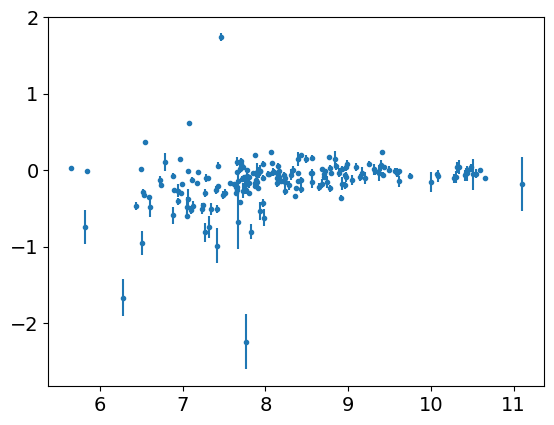

In [14]:
ek.errorbar(
    weisz['logM*'],
    weisz['logR+k'],
    yerr=weisz['u_loghanii'],
    markersize=3,
)

In [15]:
lee = ascii.read('/Users/kadofong/work/surveys/literature_ref/lee2009/tab1_processed.txt', format='cds')

In [16]:
uv_color = (galex_df['fuv_mag'] - galex_df['nuv_mag']).reindex(ms.index).values
afuv_fromuv = (3.38 * uv_color - 0.022) # Hao+2011

In [17]:
av_fromuv = observer.alambda_to_av(afuv_fromuv,1548.85)
anuv_fromuv = np.array([ observer.extinction_correction(2303.,av, return_magcorr=True)[0]\
                        for av in av_fromuv])

In [18]:
dist = modeling.cosmo.luminosity_distance(galex_df.reindex(ms.index)['z_spec']).to(u.cm)
halum = n708_fluxes[0] * 4.*np.pi*dist**2
u_halum = n708_fluxes[1] * 4.*np.pi*dist**2

fuvflux_obs = 3631.*10.**(galex_df.reindex(ms.index)['fuv_mag'].values/-2.5)*u.Jy
u_fuvflux_obs = np.abs(0.4*fuvflux_obs*np.log(10.)) * galex_df.reindex(ms.index)['fuv_magerr'].values
fuv_extcorr = extinction_correction[:,0] #10.**(afuv_fromuv/2.5)
fuvflux = fuvflux_obs * ge_correction[:,0] * fuv_extcorr #* extinction_correction[:,0]
fuvflux_old = fuvflux_obs * ge_correction[:,0] * fuv_extcorr
u_fuvflux = u_fuvflux_obs * ge_correction[:,0] * 10.**(afuv_fromuv/2.5) #* extinction_correction[:,0]
fudge = 1.#10.**-0.4
fuvlum = fuvflux * 4.*np.pi*dist**2 * fudge
u_fuvlum = u_fuvflux * 4.*np.pi*dist**2 * fudge

nuvflux_obs = 3631.*10.**(galex_df.reindex(ms.index)['nuv_mag'].values/-2.5)*u.Jy
u_nuvflux_obs = np.abs(0.4*nuvflux_obs*np.log(10.)) * galex_df.reindex(ms.index)['nuv_magerr'].values


nuv_extcorr = extinction_correction[:,1] # 10.**(anuv_fromuv/2.5)
nuvflux = nuvflux_obs * ge_correction[:,1] * nuv_extcorr
u_nuvflux = u_nuvflux_obs * ge_correction[:,1] * nuv_extcorr
nuv_width = 769*u.AA
nuvflux_ig = calibrations.fnu_to_flambda(nuvflux, 2303.37*u.AA)*nuv_width
nuvlum_ig = nuvflux_ig * 4.*np.pi*dist**2
nuvlum = nuvflux * 4.*np.pi*dist**2
u_nuvlum = u_nuvflux * 4.*np.pi*dist**2

sfrha = calibrations.LHa2SFR(halum)
sfrfuv = calibrations.convert_imf(calibrations.LUV2SFR_K98(fuvlum), 'salpeter', scale='linear')
sfrnuv = calibrations.LNUV2SFR_IP(nuvlum_ig.to(u.Lsun).value)

ratio = np.log10((halum/fuvlum).to(u.Hz).value)
#\\ from GAMA
sys_arr = np.genfromtxt("../local_data/intermediates/flux_systematics.txt")
systematic_ha = np.interp(np.log10(n708_fluxes[0]/n708_fluxes[0].unit), sys_arr[0], sys_arr[1] )
#systematic_afuv = 0.23 # Hao + 11 Conclusions, point 2
uncertainty_afuv = 0.# np.sqrt((0.48 * uv_color/2.5)**2) # statistical uncertainty in the calibration
systematic_afuv = 0. #.23 # observed scatter from mean relation
systematic = np.sqrt(systematic_ha**2 + uncertainty_afuv**2 + systematic_afuv**2)
u_ratio = np.sqrt((u_halum/(halum*np.log(10.)))**2 + systematic**2 + (u_fuvlum/(fuvlum*np.log(10.)))**2)

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_21301/315033761.py:32: RuntimeWarning: invalid value encountered in log10
  ratio = np.log10((halum/fuvlum).to(u.Hz).value)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_21301/2042894725.py:4: RuntimeWarning: invalid value encountered in log10
  *sampling.fmasker(ms.loc[mask,'logmass_corrected'].values,np.log10(sfrha[mask].value)),


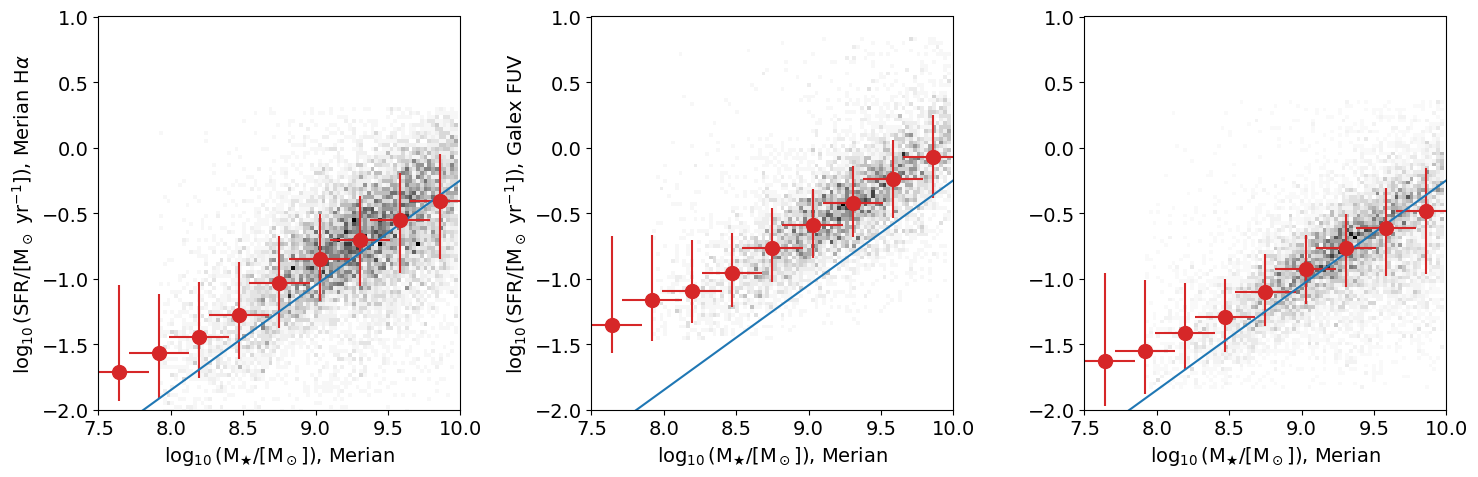

In [19]:
fig, axarr = plt.subplots(1,3,figsize=(15,5))
mask = (ms['logmass_corrected']>6.)&(ms['logmass_corrected']<10.)
pfit = np.polyfit(
    *sampling.fmasker(ms.loc[mask,'logmass_corrected'].values,np.log10(sfrha[mask].value)),
    1
)

for idx, sfr in enumerate([np.log10(sfrha[mask].value),np.log10(sfrfuv[mask]),np.log10(sfrnuv[mask])]):
    masses = ms.loc[mask,'logmass_corrected']
    ek.hist2d(
        masses,
        sfr,
        bins=80,
        ax=axarr[idx]
    )
    ek.running_quantile(
        masses,
        sfr,
        bins=np.linspace(7.5,10.,10),
        ax=axarr[idx],
        color='tab:red',
        markersize=10
    )

mx = np.linspace(6.,10.,100)
for ax in axarr:
    ax.plot(
        mx,
        0.8 * (mx-8.5) - 1.45
    )
    ax.set_xlim(7.5,10.)
    ax.set_ylim(-2., 1.)
    ax.set_xlabel(f'{ek.common_labels["logmstar"]}, Merian')
axarr[0].set_ylabel(ek.common_labels['logsfr'] + r", Merian H$\alpha$")
axarr[1].set_ylabel(ek.common_labels['logsfr'] + r", Galex FUV")

plt.tight_layout ()


In [20]:
len(ms['logmass_corrected'])

14823

In [21]:
bi = fit.BaseInferer()
bi.set_predict( lambda x, c: c )
lnP = bi.define_gaussianlikelihood(bi.predict, with_intrinsic_dispersion=True)
bi.set_loglikelihood(lnP)
bi.set_uniformprior([[10.,20.],[0.,5.]])

fn = lambda y: slicemass(y,ms['MB'])
data = (
    fn(ms['logmass_corrected']),
    fn(ratio),
    fn(u_ratio),
    None
)
bi.run(data)
bestfit = bi.get_param_estimates()[1]

NameError: name 'slicemass' is not defined

In [394]:
y_intr = np.random.normal(bestfit[0], bestfit[1], data[1].size)
y_obs = np.random.normal(y_intr, data[2], data[1].size)
y_intr.std(), np.nanstd(y_obs), np.nanstd(sampling.fmasker(data[1]))

(0.07469930024174386, 0.6530651983542343, 0.350748859563475)

Text(0.5, 0, '$\\mathcal{R}=\\log_{10}(\\rm L(H\\alpha)/L(\\rm FUV))$')

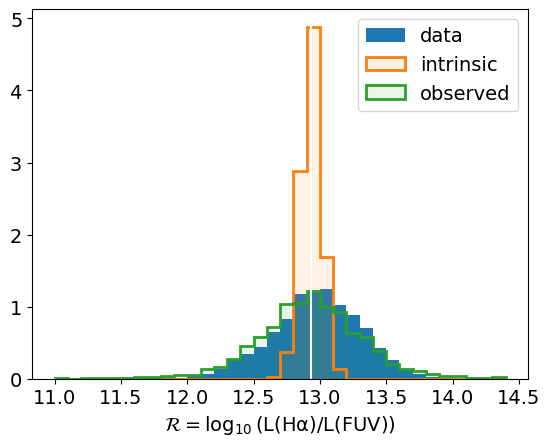

In [395]:
kwargs = {'density':True, 'bins':np.arange(11.,14.5,0.1)}
out=ek.hist(data[1],label='data', **kwargs)

ek.hist(
    y_intr[np.isfinite(data[1])],
    lw=2, 
    alpha=0.1, 
    label='intrinsic',
    #weights=np.ones_like(y_intr[np.isfinite(data[1])])*out[1][0].max(),
    **kwargs,
)
_=ek.hist(
    y_obs,
    lw=2, 
    alpha=0.1, 
    label='observed',
    **kwargs
)
plt.legend()
plt.axvline(bestfit[0], color='w')
plt.xlabel(ek.common_labels['hauv'])

In [266]:
#assns, bin_edges = sampling.bin_by_count(ms['Mr'], 2000, dx_min=0.1)
bin_edges = np.arange(7.25, 9.75, 0.25)#-20., -16., 0.5)
bi_l = []


for idx in range(len(bin_edges)-1):
    bi = fit.BaseInferer()
    bi.set_predict( lambda x, c: c )
    
    bi.set_loglikelihood(lnP)
    bi.set_uniformprior([[10.,20.],[0.,5.]])
    
    fn = lambda y: slicemass(y,ms['logmass_corrected'],logmmin=bin_edges[idx], logmmax=bin_edges[idx+1])
    data = (
        fn(ms['logmass_corrected']),
        fn(ratio),
        fn(u_ratio),
        None
    )
    bi.run(data)
    bi_l.append(bi)

100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 350.88it/s]


Re-initializing walkers...
max(GR) = 1.212


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 350.19it/s]


Re-initializing walkers...
max(GR) = 1.085
Convergence achieved


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 349.15it/s]


Re-initializing walkers...
max(GR) = 1.061
Convergence achieved


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 317.38it/s]


Re-initializing walkers...
max(GR) = 1.051
Convergence achieved


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 327.28it/s]


Re-initializing walkers...
max(GR) = 1.051
Convergence achieved


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 331.77it/s]


Re-initializing walkers...
max(GR) = 1.042
Convergence achieved


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 317.85it/s]


Re-initializing walkers...
max(GR) = 1.042
Convergence achieved


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 301.63it/s]


Re-initializing walkers...
max(GR) = 1.038
Convergence achieved


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 276.83it/s]


Re-initializing walkers...
max(GR) = 1.050
Convergence achieved


100%|██████████████████████████████████████████| 500/500 [00:01<00:00, 258.04it/s]

Re-initializing walkers...
max(GR) = 1.043
Convergence achieved


In [375]:
#assns, bin_edges = sampling.bin_by_count(ms['Mr'], 2000, dx_min=0.1)
bin_edges = np.arange(7.25, 9.75, 0.25)#-20., -16., 0.5)
weiszfit_l = []


for idx in range(len(bin_edges)-1):
    bi = fit.BaseInferer()
    bi.set_predict( lambda x, c: c )
    
    bi.set_loglikelihood(lnP)
    bi.set_uniformprior([[10.,20.],[0.,5.]])
    
    fn = lambda y: slicemass(y,weisz['logM*'],logmmin=bin_edges[idx], logmmax=bin_edges[idx+1])
    data = (
        fn(weisz['logM*']),
        fn(weisz['logR+k'] - kappa),
        fn(weisz['u_loghanii']),
        None
    )
    bi.run(data)
    weiszfit_l.append(bi)


100%|██████████████████████████████████████████| 500/500 [00:02<00:00, 227.54it/s]


Re-initializing walkers...
max(GR) = 1.141
Convergence achieved


100%|██████████████████████████████████████████| 500/500 [00:02<00:00, 227.62it/s]


Re-initializing walkers...
max(GR) = 1.055
Convergence achieved


100%|██████████████████████████████████████████| 500/500 [00:02<00:00, 223.87it/s]


Re-initializing walkers...
max(GR) = 1.056
Convergence achieved


100%|██████████████████████████████████████████| 500/500 [00:02<00:00, 220.72it/s]


Re-initializing walkers...
max(GR) = 1.054
Convergence achieved


100%|██████████████████████████████████████████| 500/500 [00:02<00:00, 225.59it/s]


Re-initializing walkers...
max(GR) = 1.076
Convergence achieved


100%|██████████████████████████████████████████| 500/500 [00:02<00:00, 229.05it/s]


Re-initializing walkers...
max(GR) = 1.055
Convergence achieved


100%|██████████████████████████████████████████| 500/500 [00:02<00:00, 222.68it/s]


Re-initializing walkers...
max(GR) = 1.061
Convergence achieved


100%|██████████████████████████████████████████| 500/500 [00:02<00:00, 234.10it/s]


Re-initializing walkers...
max(GR) = 1.109
Convergence achieved


100%|██████████████████████████████████████████| 500/500 [00:02<00:00, 226.56it/s]

Re-initializing walkers...
max(GR) = 1.088
Convergence achieved


In [267]:
refcolors=['tab:red','tab:orange']
reference = ['Weisz+2012','Lee+2009']

mcolor = ec.ColorBase(colorlists.merian['bold'])

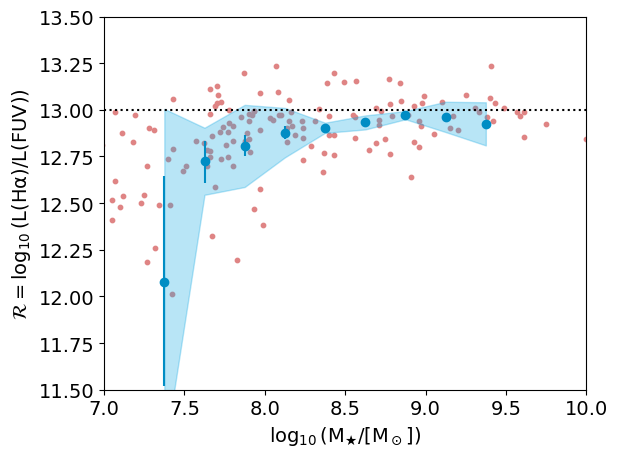

In [407]:
kappa=13.
assns,wbins = sampling.bin_by_count(
    np.where(
        (weisz['logM*']>7.)&(weisz['logM*']<9.6), 
        weisz['logM*'], 
        np.NaN
    ),
    20
)
plt.scatter(
    weisz['logM*'],
    weisz['logR+k'] + kappa,
    s=10,
    color=ec.ColorBase(refcolors[0]).modulate(0.2,-0.1).base,
)
    

for cc,fit_l in zip([mcolor,ec.ColorBase(refcolors[0])],[bi_l, weiszfit_l]):
    ym = np.array([ bi.get_param_estimates()[1,0] for bi in fit_l])
    uy = np.array([ bi.get_param_estimates()[1,1] for bi in fit_l])
    ek.errorbar(
        sampling.midpts(bin_edges),
        ym,
        ylow=np.array([ bi.get_param_estimates()[0,0] for bi in  fit_l]),
        yhigh=np.array([ bi.get_param_estimates()[2,0] for bi in fit_l]),
        #label='Merian',
        color=cc.modulate(-0.1,0.3).base,
    )

    plt.fill_between(
        sampling.midpts(bin_edges),
        ym-uy,
        ym+uy,
        color=cc.base,
        alpha=0.3
    )
        
    break

    
plt.ylim(11.5, 13.5)
plt.xlim(7., 10.)
plt.axhline(kappa, color='k', ls=':')

plt.xlabel(ek.common_labels['logmstar'])
plt.ylabel(ek.common_labels['hauv'])
plt.tight_layout ()
plt.savefig('/Users/kadofong/Desktop/hafuv.png')

In [403]:
bi.get_param_estimates()[1]

array([12.93043557,  0.07521754])

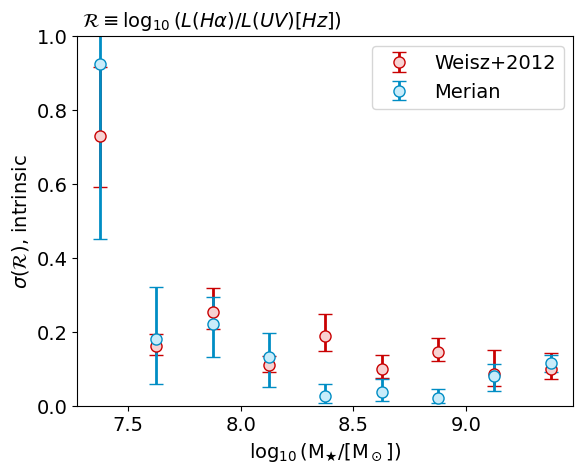

In [389]:
assns,wbins = sampling.bin_by_count(np.where((weisz['logM*']>7.)&(weisz['logM*']<9.6), weisz['logM*'], np.NaN), 20)
#wbins = np.linspace(7., 9.6, 30)
merr = 0.2
_, wstd, _ = sampling.running_metric(
    *sampling.fmasker(weisz['logM*'],weisz['logR+k']),
    np.nanstd, 
    wbins,
    dx=np.diff(wbins)[0],
    xerr=0.2, 
    yerr=0., 
    erronmetric=True
)
if False:
    ek.errorbar(
        wbins,
        wstd[:,0,2],
        ylow=wstd[:,0,1],
        yhigh=wstd[:,0,3],
        color=ec.ColorBase(refcolors[0]).base,
        lw=1,
        markersize=5,
        markerfacecolor='w',
    )

cc_l = [ec.ColorBase(refcolors[0]), mcolor]
tags_l  = ['Weisz+2012','Merian']
for idx,fit_l in enumerate([weiszfit_l, bi_l]):
    cc = cc_l[idx]
    label = tags_l[idx]
    ek.errorbar(
        sampling.midpts(bin_edges),
        [ bi.get_param_estimates()[1,1] for bi in fit_l],
        ylow=np.array([ bi.get_param_estimates()[0,1] for bi in fit_l]),
        yhigh=np.array([ bi.get_param_estimates()[2,1] for bi in fit_l]),
        #label='Merian',
        color=cc.modulate(-0.1,0.3).base,
        markerfacecolor=cc.modulate(0.4).base,
        lw=2, 
        label=label,
        markersize=8,
        capsize=5
    )



ek.text(
    0.01, 
    1.01,
    r'$\mathcal{R}\equiv\log_{10}(L(H\alpha)/L(UV) [Hz])$',
    va='bottom'
)
plt.ylim(0., 1.)
plt.legend()
plt.xlabel(ek.common_labels['logmstar'])
plt.ylabel(r'$\sigma(\mathcal{R})$, intrinsic')
plt.savefig("/Users/kadofong/Desktop/hafuv.pdf", bbox_inches='tight')

(-22.0, -14.0)

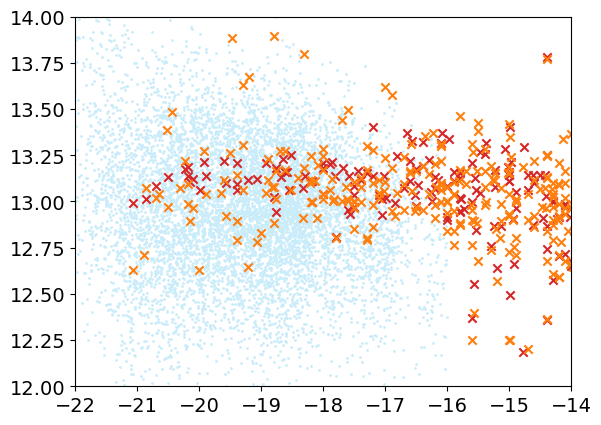

In [270]:
plt.scatter(
    ms['Mr'],
    ratio,
    s=1,
    color=mcolor.modulate(0.4).base
)

for idx in range(len(bi_l)):
    params = bi_l[idx].get_param_estimates()[1]
    x = (ms['Mr']>bin_edges[idx])&(ms['Mr']<bin_edges[idx+1])
    ek.errorbar(
        0.5*(bin_edges[idx]+bin_edges[idx+1]),
        params[0],
        yerr=np.nanstd(sampling.fmasker(x)),
        color=mcolor.modulate(0.2).base,
        #linestyle=':'
        #markersize=0
    )   

    ek.errorbar(
        0.5*(bin_edges[idx]+bin_edges[idx+1]),
        params[0],
        yerr=params[1],
        color=mcolor.base,
        capsize=3
        #markersize=0
    )
kappa = -13.17
plt.scatter(
    weisz['BMag'],
    weisz['logR+k'] - kappa,
    color=refcolors[0],
    marker='x'
)
plt.scatter(
    lee['BMag'],
    lee['loghalum'] - lee['loguvlum'],
    color=refcolors[1],
    marker='x'
)
plt.ylim(12.,14.)
plt.xlim(-22.,-14.)

In [523]:
mass_to_mr = np.poly1d(
    np.polyfit(
        *sampling.fmasker(
            np.where((ms['z500']>0.051)&(ms['z500']<0.1),ms['logmass_corrected'], np.NaN),
            ms['Mr']
        ),
        1
    )
)
                    

In [526]:
mass_to_mr(8.),mass_to_mr(9.)

(-17.372363953630153, -19.286056786722863)

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_63623/2807065315.py:3: RuntimeWarning: invalid value encountered in log10
  out = ek.hist(slicemass(np.log10((halum/fuvlum).to(u.Hz).value), ms['logmass_gaap']),**kwargs)


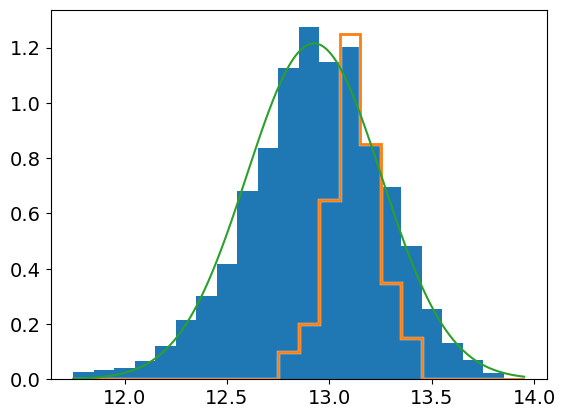

In [162]:
bins = np.arange(11.75, 14., 0.1)
kwargs = {'density':True, 'bins':bins}
out = ek.hist(slicemass(np.log10((halum/fuvlum).to(u.Hz).value), ms['logmass_corrected']),**kwargs)
wx = slicemass(weisz['logR+k']-kappa, weisz['logM*'])
ek.hist(wx, histtype='step', lw=2, weights=np.ones(len(wx))/20,
        bins=bins)

rgrid = np.linspace(bins.min(),bins.max(),500)
bestfit = bi.get_param_estimates()[1]
plt.plot(
    rgrid,
    functions.gaussian(rgrid, 'normalize', *bestfit)
)
    

# Model Completeness

In [25]:
MrLF = modeling.BroadbandLuminosityFunction()
MrLF.set_parameters('../local_data/inputs/absmagr_lf.dat')

In [26]:
SFS = modeling.StarFormingSequence()

In [27]:
HaLF = modeling.HalphaLuminosityFunction(MrLF, SFS)

In [28]:
from scipy import integrate

In [29]:
from ekfstats import fit, sampling

In [763]:
mr_obs = utils.flux2mag(merian_select['r_cModelFlux_Merian'][merian_select['r_cModelFlux_Merian'] >0.])
merian_area = 300.# * u.deg**2

out = np.histogram(mr_obs, weights=np.ones_like(mr_obs)/np.diff(mrbins)[0], bins=mrbins )
boneheaded = HaLF.predict_dSigmadmr(mrbins=sampling.midpts(out[1]))[1]*merian_area
mcompleteness = interpolate.interp1d(sampling.midpts(out[1]), out[0]/boneheaded)

p_observe_mr = mcompleteness(mr_obs)

In [766]:
ew_completeness = modeling.Model()
ew_completeness.set_parameters('../local_data/intermediates/ew_completeness_parameters.txt')
ew_completeness.set_model( lambda x, *theta: (functions.sigmoid(x,theta[0],theta[1]) + theta[2])*(1.-theta[2]) )


sample = np.log10(n708_luminosities[0].value)
p_observe_ew = ew_completeness.predict(np.log10(n708_eqws[0].value))
volume = (formica.cosmo.comoving_volume(0.1) - formica.cosmo.comoving_volume(0.051)).value

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_61969/2359048034.py:6: RuntimeWarning: invalid value encountered in log10
  sample = np.log10(n708_luminosities[0].value)


Text(0, 0.5, 'EW(H$\\alpha$) [$\\rm \\AA$]')

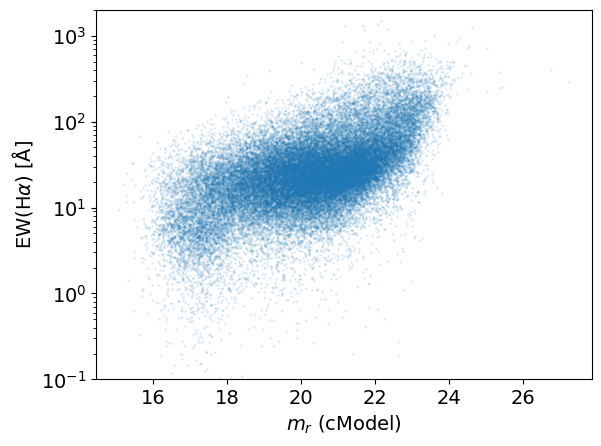

In [778]:
plt.scatter(
    mr_obs,
    #np.log10(n708_luminosities[0]/(u.erg/u.s)),
    n708_eqws[0],
    s=1,
    alpha=0.1
)
plt.yscale('log')
plt.ylim(0.1, 2e3)
plt.xlabel(r'$m_r$ (cModel)')
plt.ylabel(r'EW(H$\alpha$) [$\rm \AA$]')

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_61969/2945650279.py:1: RuntimeWarning: invalid value encountered in log10
  ek.hist(np.log10(n708_luminosities[0].value), weights=1./(p_observe_ew*p_observe_mr), density=True)


(<Axes: >,
 (array([0.06996159, 0.15123336, 0.28647089, 0.47809778, 0.6159205 ,
         0.70090848, 0.67651079, 0.64064134, 0.59798577, 0.57455753,
         0.50508066, 0.45483111, 0.39278666, 0.32282507, 0.26837459,
         0.20180606, 0.15898892, 0.09936808, 0.06543751]),
  array([38.92866348, 39.06637063, 39.20407779, 39.34178495, 39.4794921 ,
         39.61719926, 39.75490642, 39.89261357, 40.03032073, 40.16802789,
         40.30573505, 40.4434422 , 40.58114936, 40.71885652, 40.85656367,
         40.99427083, 41.13197799, 41.26968514, 41.4073923 , 41.54509946]),
  [<matplotlib.patches.Polygon at 0x326a8e680>]))

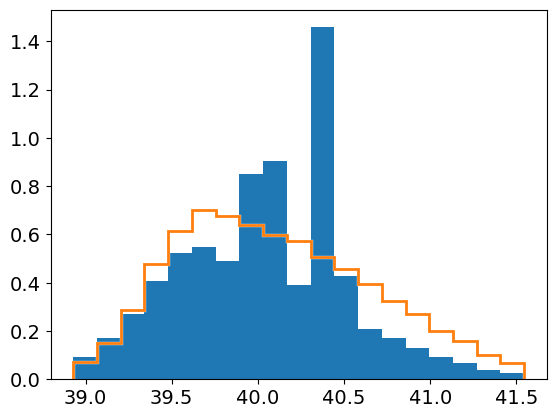

In [769]:
ek.hist(np.log10(n708_luminosities[0].value), weights=1./(p_observe_ew*p_observe_mr), density=True)
ek.hist(np.log10(n708_luminosities[0].value), density=True, histtype='step', lw=2)

In [542]:
bi = fit.BaseInferer ()

bi.set_predict(lambda loglha, logphi, M_ast, alpha: functions.logschechter(loglha, 10.**logphi, M_ast, alpha))
lnP = bi.define_poissonpointprocess_likelihood(domain=[35., 42.], volume=volume)
bi.set_loglikelihood(lnP)
bi.set_uniformprior([[-5.,1.],[35., 45.],[-3.,0.]])

In [543]:
sampling.fmasker(sample, weights)

[array([39.35197186, 40.55780207, 39.32996611, ..., 40.30793738,
        40.17608946, 39.95818855]),
 array([1.94878285, 1.53636713, 1.97309905, ..., 1.0088059 , 1.01685604,
        1.00330001])]

In [544]:
#absmag_r = np.linspace(-26.,-5.,1000)
#ntot = integrate.fixed_quad ( lambda x: 10.**(MrLF.predict(x)), -26.,-5.)[0]

#implied_volume = sample.size/ntot
weights = 1./p_observe
data = sampling.fmasker(sample,weights)
bi.run(data, steps=1000, niter=2)

100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.31it/s]


Re-initializing walkers...
max(GR) = 1.285


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.91it/s]


(<Figure size 1000x600 with 3 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

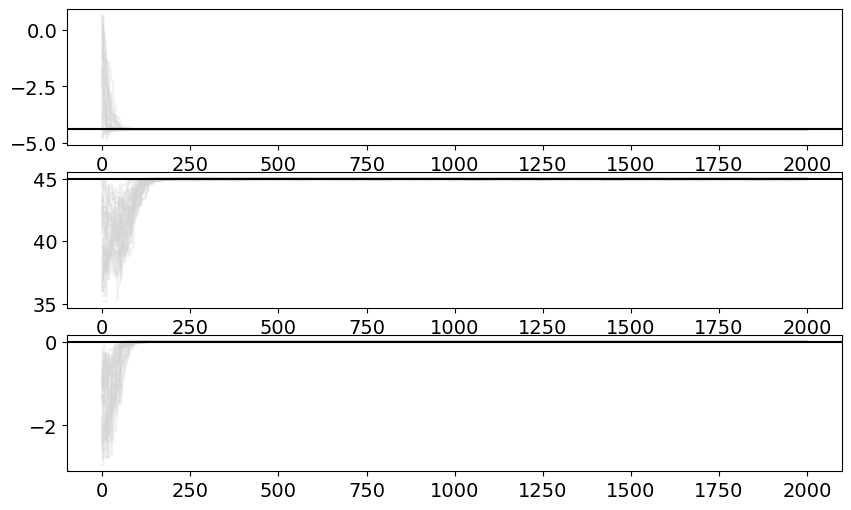

In [545]:
true_parameters = [ np.log10(MrLF.parameters[0]), MrLF.parameters[1], MrLF.parameters[2] ]
bi.plot_chain()#truth=true_parameters)

In [550]:
np.nanmin(p_observe)

0.0533148712602243

(<Axes: >,
 (array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         7.55349433e-09, 7.55349433e-09, 3.77674717e-08, 5.28744603e-08,
         5.13637615e-07, 4.36591972e-06, 4.85009871e-05, 1.13732964e-04,
         9.44035722e-05, 5.90003442e-05, 2.32798695e-05, 4.09399393e-06,
         2.41711819e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00]),
  array([34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. , 38.5, 39. ,
         39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5, 44. , 44.5]),
  <BarContainer object of 21 artists>))

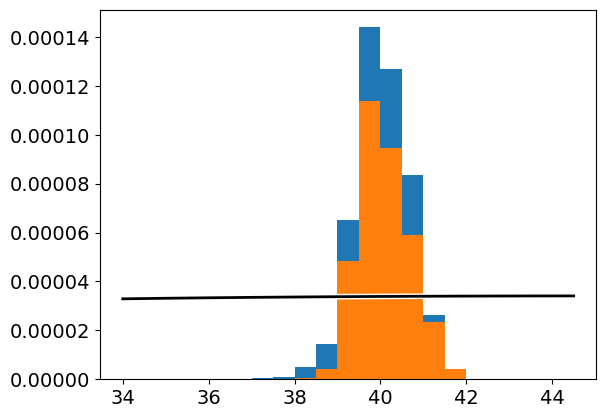

In [551]:
dm = 0.5
bins = np.arange(34., 45.,dm)

bi.plot_uncertainties(bins)
ek.hist(sample, weights=np.ones_like(sample)/p_observe/volume/dm, bins=bins)
ek.hist(sample, weights=np.ones_like(sample)/volume/dm, bins=bins)

#ek.hist(sample[is_observed], weights=np.ones_like(sample[is_observed])/implied_volume/dm, bins=bins)
#plt.plot(
#    absmag_r,
#    10.**MrLF.predict(absmag_r),
#    ls='--',
#    color='r'
#)
#plt.yscale('log')

In [280]:
xdata = np.linspace(36., 42.5, 300)
ytrue = np.log10(functions.logschechter(10.**logLHa_x, 10.**-3.14, 10.**42.05, -1.59)) # Ly +07
true_parameters = [-0.25, 35.87,  0.3, 0.5,0.5,-15.,0.8] 
ytrue = np.log10(HaLF.predict_lhalf(xdata, *true_parameters))
#np.log10(predict_lhalf(logLHa_x, *sfs.parameters))
yerr = 0.01
yobs = np.random.normal(ytrue, yerr)

/Users/kadofong/work/projects/merian/formica/formica/modeling.py:57: RuntimeWarning: divide by zero encountered in log10
  lambda *args: np.log10(functions.logschechter_mag(*args))


In [281]:
HaLF.fit(xdata, yobs, np.ones_like(yobs)*yerr)

100%|█████████████████████████████████████████| 500/500 [03:08<00:00,  2.66it/s]


(<Figure size 1000x1400 with 7 Axes>,
 array([<Axes: ylabel='m(SFR)'>, <Axes: ylabel='b(SFR)'>,
        <Axes: ylabel='$\\sigma$(SFR)'>, <Axes: ylabel='ceil'>,
        <Axes: ylabel='floor'>, <Axes: ylabel='$M_r^\\ast$'>,
        <Axes: ylabel='k'>], dtype=object))

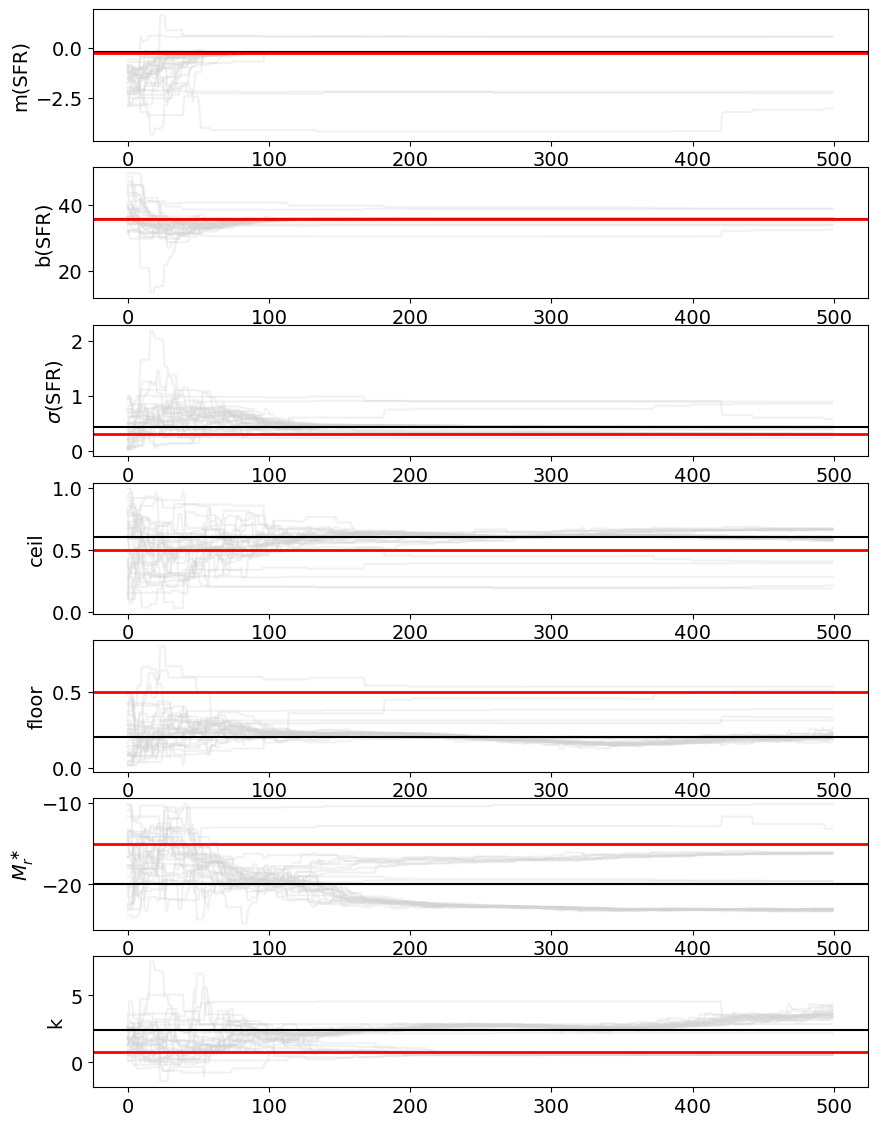

In [282]:
HaLF.model.plot_chain(
    truth=true_parameters,
    labels=[r'm(SFR)', 'b(SFR)', r'$\sigma$(SFR)','ceil','floor',r'$M_r^\ast$', 'k']
)

In [283]:
bestfit = HaLF.model.get_param_estimates()[1]

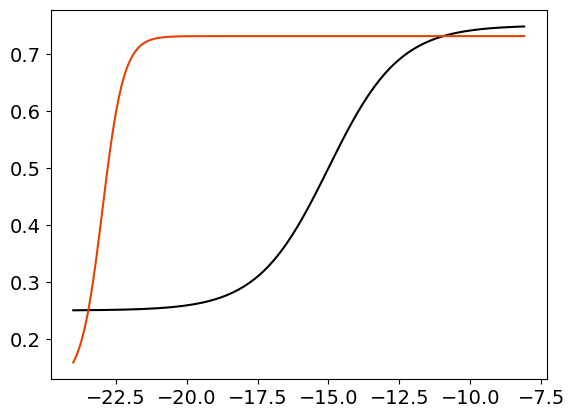

In [290]:
plt.plot(
    absmag_r,
    SFS.starforming_fraction(absmag_r, true_parameters[3:]),
    color='k'
)
plt.plot(
    absmag_r,
    SFS.starforming_fraction(absmag_r, bestfit[3:]),
    color=colorlists.merian['highlight']
)

In [291]:
logew, ewpdf = HaLF.predict_ewpdf(*bestfit)
logew_true, ewpdf_true = HaLF.predict_ewpdf(*true_parameters)

/Users/kadofong/work/projects/merian/formica/formica/modeling.py:57: RuntimeWarning: divide by zero encountered in log10
  lambda *args: np.log10(functions.logschechter_mag(*args))


In [286]:
normalize = lambda x, y: y / y.max()

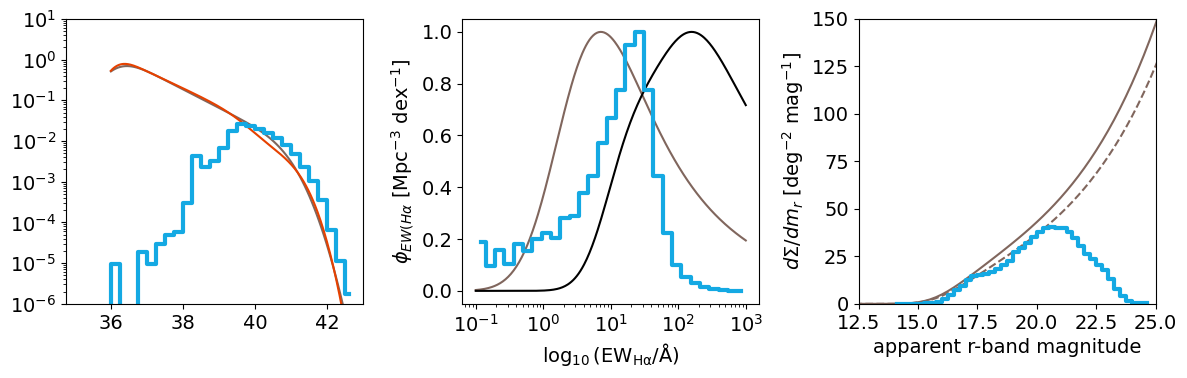

In [292]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
model_color = ec.ColorBase(colorlists.merian['darkdim'])

ax = axarr[0]
loghalum_x = np.linspace(36., 42.5, 100)
ax.plot(
    loghalum_x,
    HaLF.predict_lhalf(loghalum_x, *bestfit),
    color=model_color.base,
    lw=1.5
)
ax.plot(
    xdata,
    10.**ytrue,
    color=ec.ColorBase(colorlists.merian['highlight']).base
)
mc = np.genfromtxt('/tmp/merian_half.dat')
ax.step(mc[0],mc[1], where='mid', lw=3, color=colorlists.merian['bold'])
ax.set_yscale('log')
ax.set_ylim(1e-6, 1e1)

ax = axarr[1]
ax.plot(10.**logew, normalize(logew, ewpdf / (10.**logew * np.log(10.))), color=model_color.base)
ax.plot(10.**logew_true, normalize(logew_true, ewpdf_true / (10.**logew_true * np.log(10.))), color='k')

mc = np.genfromtxt('/tmp/merian_ew.dat')
ax.step(mc[0], normalize(mc[0],mc[1]), where='mid', lw=3, color=colorlists.merian['bold'])
ax.set_xscale('log')
ax.set_xlabel(ek.convert_label_to_log(ek.common_labels['haew']))
ax.set_ylabel(r'$\phi_{EW(H\alpha}\ \rm [Mpc^{-3}\ dex^{-1}]$')


ax = axarr[2]
mc = np.genfromtxt('/tmp/merian_mrcounts.txt')
mrbins, surfdens = HaLF.predict_dSigmadmr()
ax.plot(mrbins, surfdens, color=model_color.base)
ax.plot(mrbins, 0.85*surfdens, color=model_color.base, ls='--')
ax.step(mc[1],mc[0], where='mid', lw=3, color=colorlists.merian['bold'])

ax.set_ylim(0.,150)
ax.set_xlim(12.5,25.)

ax.set_xlabel('apparent r-band magnitude')
ax.set_ylabel(r'$d\Sigma/dm_r$ [deg$^{-2}$ mag$^{-1}$]')

plt.tight_layout ()


0.9979705096916917